## Data

### Load

In [1]:
import pandas as pd

df = pd.read_csv("PCE.csv", parse_dates=["DATE"], index_col="DATE")

# Since data is Monthly, we need to set the frequency to Monthly
df.index.freq = "MS"

### Data Info

In [2]:
# Check that the index is a DatetimeIndex
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [3]:
# Show the details of the index and the frequency is Monthly
print(df.index)
print("#" * 50)
print(f"Number of unique dates: {df.index.nunique()}")
print(f"Missing dates: {df.index.isna().sum()}")

DatetimeIndex(['1959-01-01', '1959-02-01', '1959-03-01', '1959-04-01',
               '1959-05-01', '1959-06-01', '1959-07-01', '1959-08-01',
               '1959-09-01', '1959-10-01',
               ...
               '2023-12-01', '2024-01-01', '2024-02-01', '2024-03-01',
               '2024-04-01', '2024-05-01', '2024-06-01', '2024-07-01',
               '2024-08-01', '2024-09-01'],
              dtype='datetime64[ns]', name='DATE', length=789, freq='MS')
##################################################
Number of unique dates: 789
Missing dates: 0


In [4]:
df.head()

PCE
DATE             
1959-01-01  306.1
1959-02-01  309.6
1959-03-01  312.7
1959-04-01  312.2
1959-05-01  316.1

In [5]:
df.tail()

PCE
DATE               
2024-05-01  19697.3
2024-06-01  19747.5
2024-07-01  19862.9
2024-08-01  19918.4
2024-09-01  20024.3

In [6]:
df.describe()

PCE
count    789.000000
mean    5759.638910
std     5252.222913
min      306.100000
25%     1026.800000
50%     4003.600000
75%     9852.400000
max    20024.300000

### Plot the Data

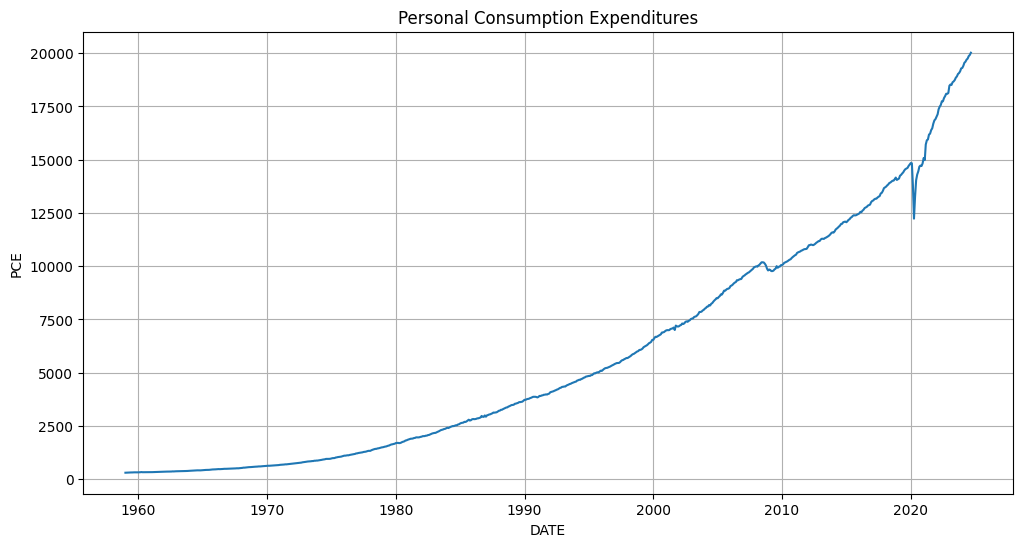

In [7]:
# plot the data statically
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.lineplot(x=df.index, y=df["PCE"])
plt.title("Personal Consumption Expenditures")
plt.grid(True)
plt.show()

In [8]:
# Plot the data dynamically
import plotly.express as px

fig = px.line(df, x=df.index, y="PCE", title="Personal Consumption Expenditures")
fig.show()

Plot observations:

- According to the time series plot of PCE data, there is an increasing trend.
- Therefore, the series is not stationary and might be a stochastic trend.
- Also, this series have non-stationarity in mean.
- Mean changes over time.
- There is no seasonal behaviour in the data.
- To see the variation of the PCE data, more specific time is plotted in the below. 

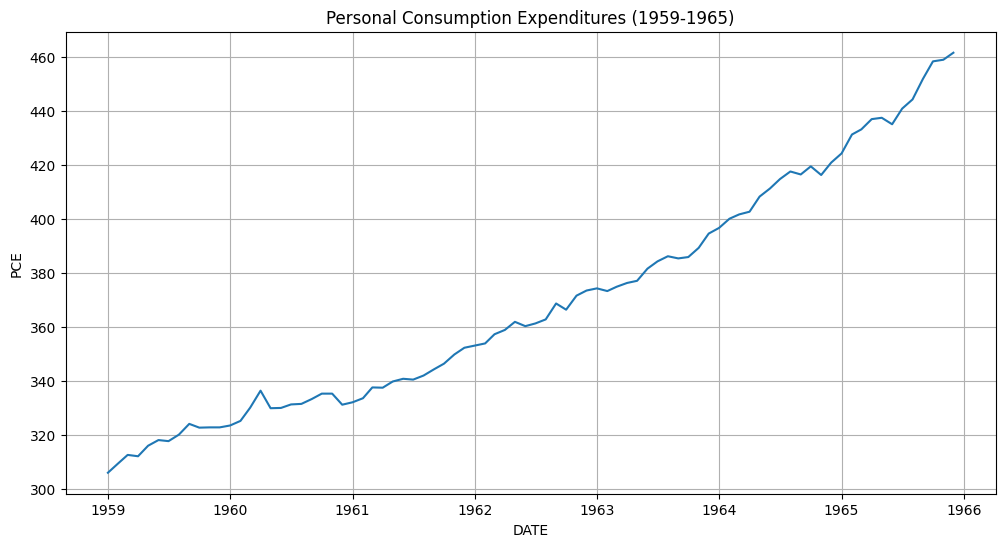

In [9]:
filtered_df = df.loc["1959-01-01":"1965-12-01"]

plt.figure(figsize=(12, 6))
sns.lineplot(x=filtered_df.index, y=filtered_df["PCE"])
plt.title("Personal Consumption Expenditures (1959-1965)")
plt.grid(True)
plt.show()

There are some fluctuations in the data

## Train and Test Split

- Split the data into train and test set
- Use the last 12 months data as test set, 777 months data as train set
    - Train set: 1959-01-01 to 2023-09-01
    - Test set: 2023-10-01 to 2024-09-01

In [10]:
from sktime.split import temporal_train_test_split

train_df, test_df = temporal_train_test_split(df, test_size=12)

In [11]:
print("** Train head **")
print("-" * 25)
print(train_df.head())

print("-" * 50)
print("** Train tail **")
print("-" * 25)
print(train_df.tail())

** Train head **
-------------------------
              PCE
DATE             
1959-01-01  306.1
1959-02-01  309.6
1959-03-01  312.7
1959-04-01  312.2
1959-05-01  316.1
--------------------------------------------------
** Train tail **
-------------------------
                PCE
DATE               
2023-05-01  18676.4
2023-06-01  18742.1
2023-07-01  18850.5
2023-08-01  18911.6
2023-09-01  19024.9


In [12]:
print("** Test head **")
print("-" * 25)
print(test_df.head())

print("-" * 50)
print("** Test tail **")
print("-" * 25)
print(test_df.tail())

** Test head **
-------------------------
                PCE
DATE               
2023-10-01  19069.5
2023-11-01  19151.0
2023-12-01  19289.9
2024-01-01  19308.5
2024-02-01  19412.7
--------------------------------------------------
** Test tail **
-------------------------
                PCE
DATE               
2024-05-01  19697.3
2024-06-01  19747.5
2024-07-01  19862.9
2024-08-01  19918.4
2024-09-01  20024.3


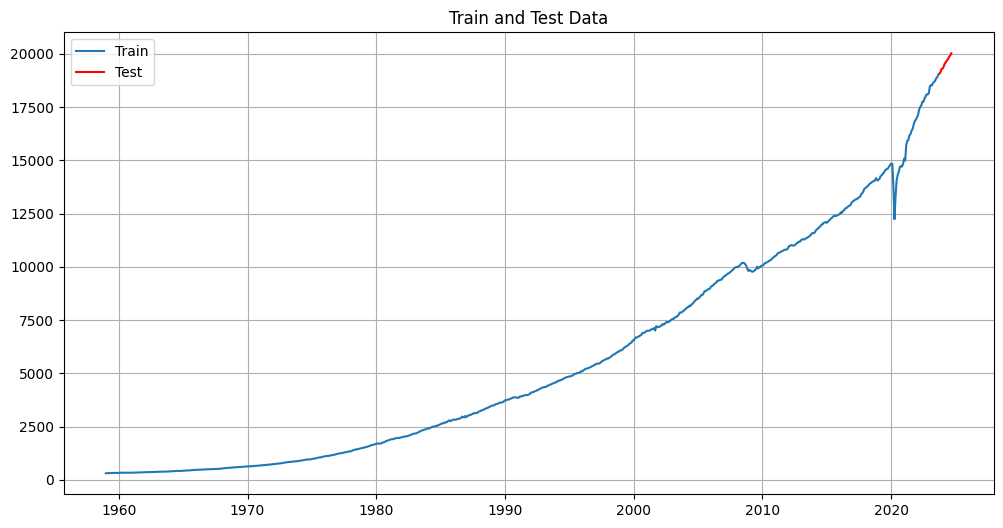

In [13]:
# Plot the train and test data
plt.figure(figsize=(12, 6))
plt.plot(train_df.index, train_df["PCE"], label="Train")
plt.plot(test_df.index, test_df["PCE"], label="Test", color="red")
plt.legend()
plt.title("Train and Test Data")
plt.grid(True)
plt.show()

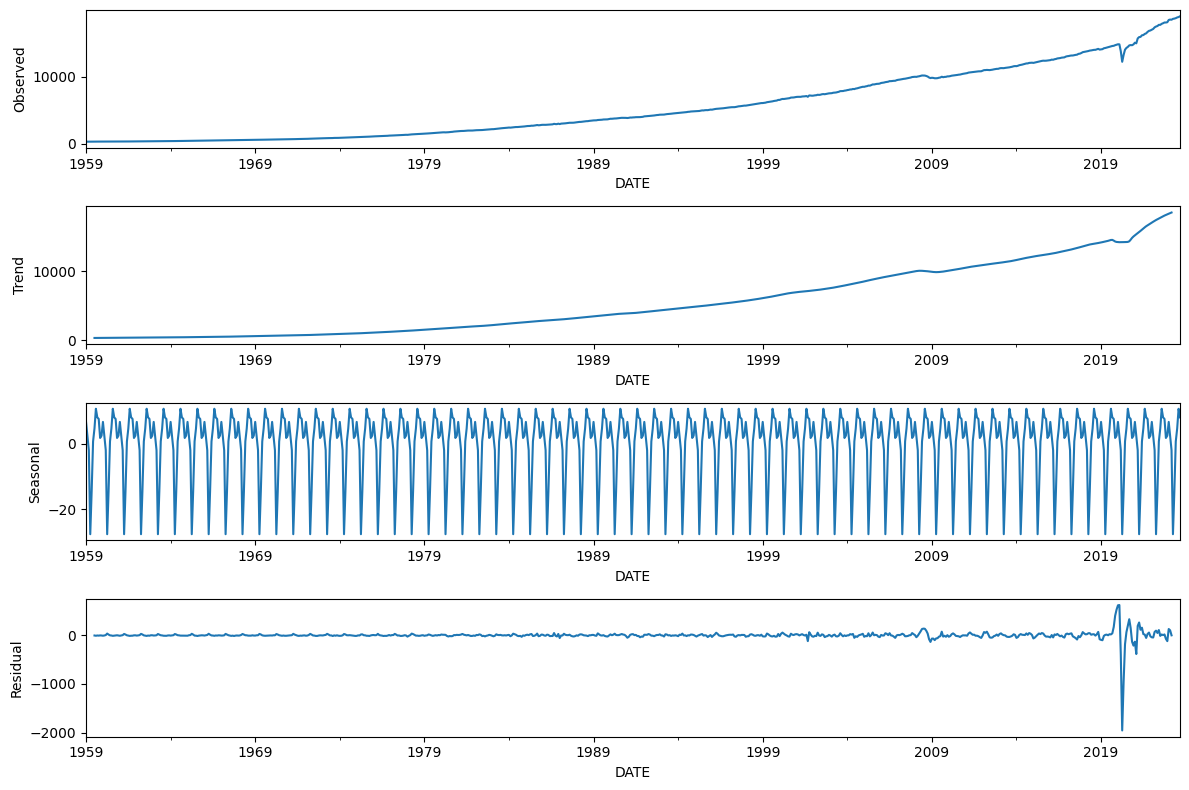

In [14]:
# Decompose the train data

from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(train_df, model="additive", period=12)

# result.plot()

# Plot the decomposed parts with details
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8))
result.observed.plot(ax=ax1)
ax1.set_ylabel("Observed")
result.trend.plot(ax=ax2)
ax2.set_ylabel("Trend")
result.seasonal.plot(ax=ax3)
ax3.set_ylabel("Seasonal")
result.resid.plot(ax=ax4)
ax4.set_ylabel("Residual")
plt.tight_layout()
plt.show()

## Anomaly Detection

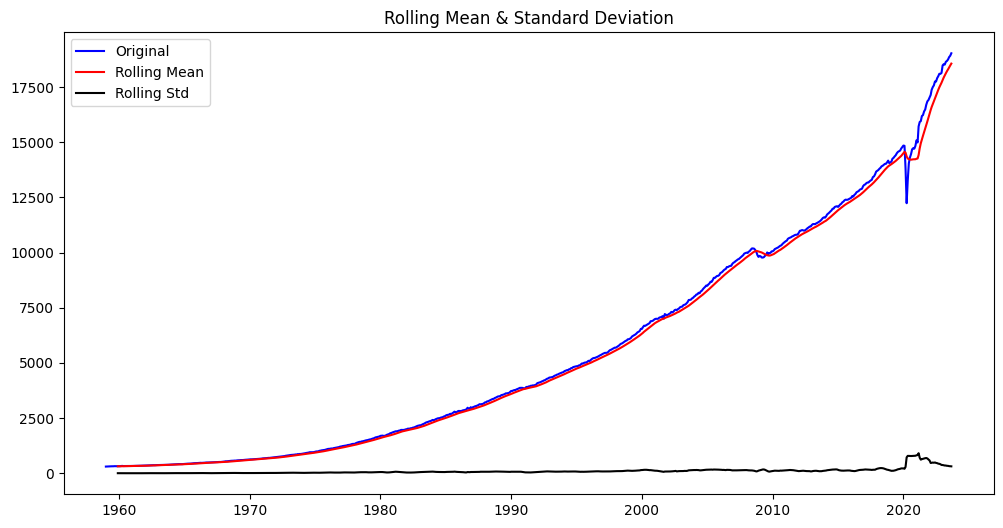

In [15]:
# Calculate Moving Statistics

# Compute rolling mean and standard deviation
rolling_mean = train_df["PCE"].rolling(window=12).mean()
rolling_std = train_df["PCE"].rolling(window=12).std()

# Plot rolling statistics
plt.figure(figsize=(12, 6))
plt.plot(train_df["PCE"], color="blue", label="Original")
plt.plot(rolling_mean, color="red", label="Rolling Mean")
plt.plot(rolling_std, color="black", label="Rolling Std")
plt.legend(loc="best")
plt.title("Rolling Mean & Standard Deviation")
plt.show()

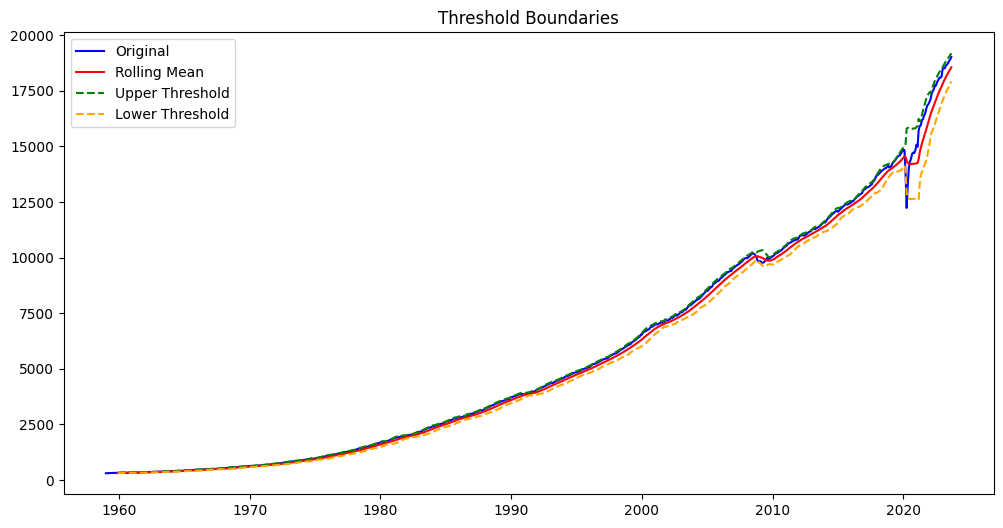

In [16]:
# Set Threshold Boundaries

# Define the number of standard deviations for the threshold
num_std_dev = 2

# Calculate upper and lower thresholds
upper_threshold = rolling_mean + (num_std_dev * rolling_std)
lower_threshold = rolling_mean - (num_std_dev * rolling_std)

# Plot the thresholds along with the original data
plt.figure(figsize=(12, 6))
plt.plot(train_df["PCE"], color="blue", label="Original")
plt.plot(rolling_mean, color="red", label="Rolling Mean")
plt.plot(upper_threshold, color="green", linestyle="--", label="Upper Threshold")
plt.plot(lower_threshold, color="orange", linestyle="--", label="Lower Threshold")
plt.legend(loc="best")
plt.title("Threshold Boundaries")
plt.show()

In [17]:
# Detect and Visualize Anomalies

# Identify anomalies
anomalies = train_df[
    (train_df["PCE"] > upper_threshold) | (train_df["PCE"] < lower_threshold)
]

print("Total anomalies detected:", anomalies.shape[0])

anomalies

Total anomalies detected: 9


PCE
DATE               
1960-04-01    336.5
1980-10-01   1817.1
1986-09-01   2971.8
1992-01-01   4084.7
2001-10-01   7212.9
2008-12-01   9801.5
2012-02-01  10987.2
2020-03-01  13810.5
2020-04-01  12234.4

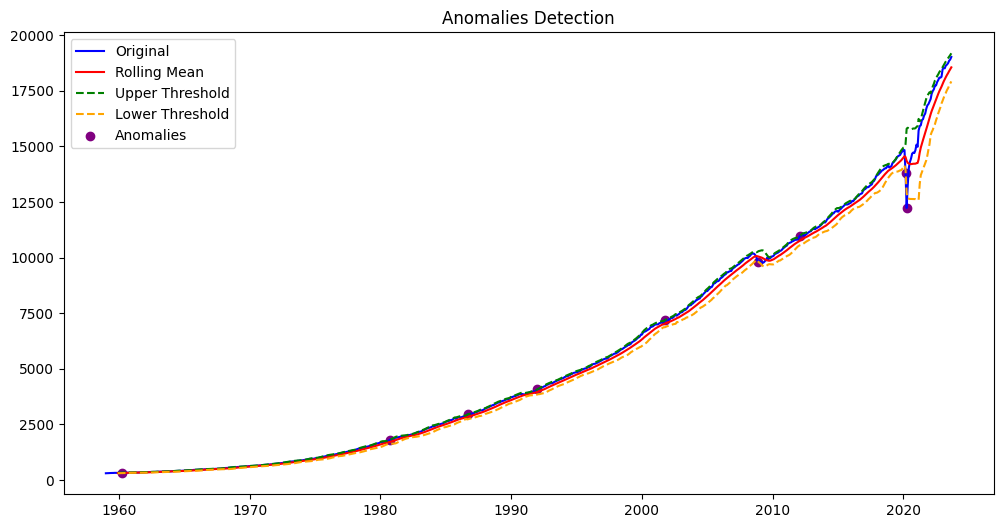

In [18]:
# Plot the anomalies
plt.figure(figsize=(12, 6))
plt.plot(train_df["PCE"], color="blue", label="Original")
plt.plot(rolling_mean, color="red", label="Rolling Mean")
plt.plot(upper_threshold, color="green", linestyle="--", label="Upper Threshold")
plt.plot(lower_threshold, color="orange", linestyle="--", label="Lower Threshold")
plt.scatter(anomalies.index, anomalies["PCE"], color="purple", label="Anomalies")
plt.legend(loc="best")
plt.title("Anomalies Detection")
plt.show()

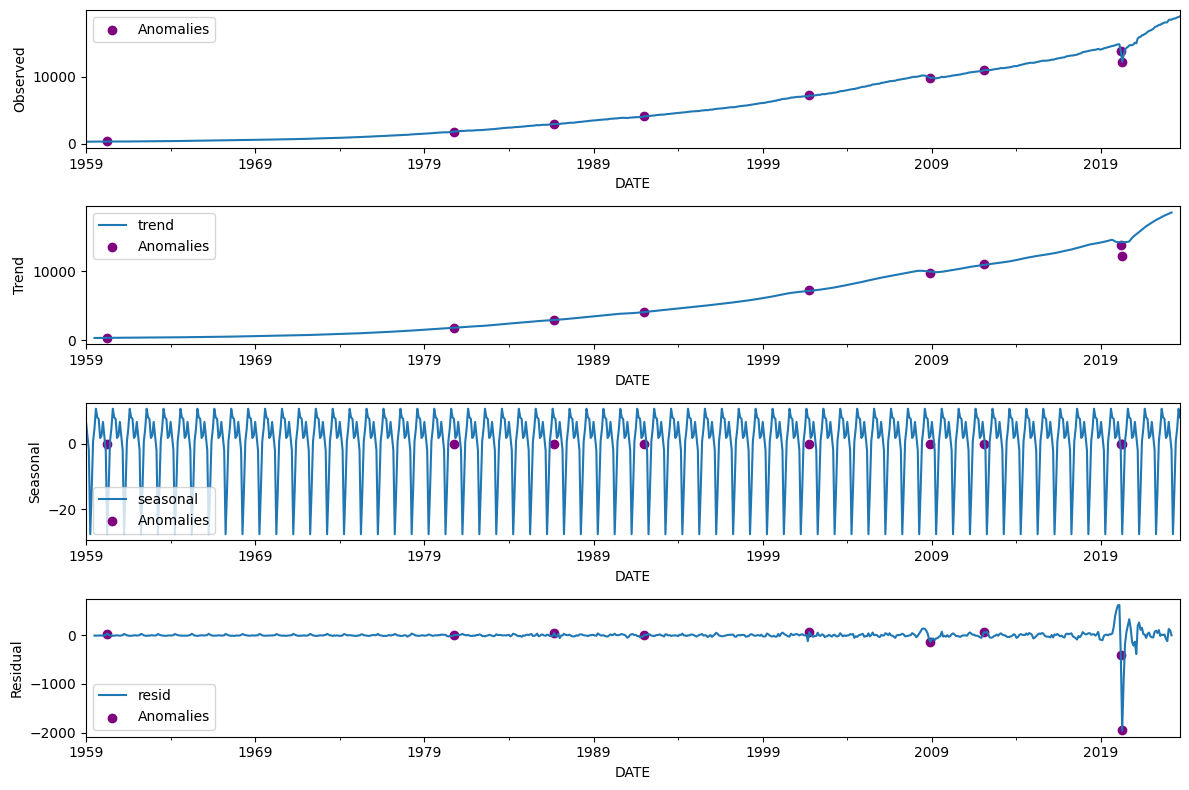

In [19]:
# Show the anomalies in the decomposed parts

from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(train_df, model="additive", period=12)

# Plot the decomposed parts with details and highlight anomalies
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8))

# Observed
result.observed.plot(ax=ax1)
ax1.scatter(anomalies.index, anomalies["PCE"], color="purple", label="Anomalies")
ax1.set_ylabel("Observed")
ax1.legend()

# Trend
result.trend.plot(ax=ax2)
ax2.scatter(anomalies.index, anomalies["PCE"], color="purple", label="Anomalies")
ax2.set_ylabel("Trend")
ax2.legend()

# Seasonal
result.seasonal.plot(ax=ax3)
ax3.scatter(
    anomalies.index, [0] * len(anomalies), color="purple", label="Anomalies"
)  # Assuming anomalies have no seasonal component
ax3.set_ylabel("Seasonal")
ax3.legend()

# Residual
result.resid.plot(ax=ax4)
ax4.scatter(
    anomalies.index,
    anomalies["PCE"]
    - result.trend.loc[anomalies.index]
    - result.seasonal.loc[anomalies.index],
    color="purple",
    label="Anomalies",
)
ax4.set_ylabel("Residual")
ax4.legend()

plt.tight_layout()
plt.show()

Major anomalies :

- COVID-19 Impact :
    - There is a dramatic drop
    - Largest monthly decline in the dataset


- 1980s Volatility:
    - Several unusual movements during economic instability period
    
    
- 2008 Financial Crisis:
    - There is a decline in late 2008

### Alternative not working

In [20]:
# from sktime.annotation.adapters import PyODAnnotator
# from pyod.models.iforest import IForest
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# # Assuming train_df exists and contains time series data
# # Create PyOD detector
# detector = IForest(contamination=0.1, random_state=42)

# # Wrap with sktime's PyODAnnotator
# annotator = PyODAnnotator(detector)

# # Fit and predict anomalies
# anomaly_labels = annotator.fit_predict(train_df)

In [21]:
# # Create visualization
# plt.figure(figsize=(15, 5))
# plt.plot(train_df.index, train_df.values, label="Data")
# anomalies = train_df[[anomaly_labels == 1]]
# plt.plot(
#     anomalies.index,
#     anomalies.index,
#     color="red",
#     linestyle="None",
#     marker="o",
#     label="Anomalies",
# )
# plt.title("Time Series with Detected Anomalies")
# plt.legend()
# plt.show()

# # Print anomaly statistics
# anomal_count = (anomaly_labels == 1).sum().sum()

# print(f"Number of anomalies detected: {anomal_count}")
# print(f"Percentage of anomalies: {anomal_count / len(train_df) * 100:.2f}%")

### Remove the Anomalies

In [22]:
# Replace and interpolate anomalies linearly
train_df_no_anomalies = train_df.copy()
train_df_no_anomalies.loc[anomalies.index] = pd.NA
train_df_no_anomalies = train_df_no_anomalies.interpolate(method="linear")

# Show the difference between the original and the interpolated data
differences = train_df.compare(train_df_no_anomalies)
differences.rename(columns={"self": "original", "other": "no_anomalies"}, inplace=True)

differences

PCE              
           original  no_anomalies
DATE                             
1960-04-01    336.5    330.100000
1980-10-01   1817.1   1803.650000
1986-09-01   2971.8   2915.750000
1992-01-01   4084.7   4060.000000
2001-10-01   7212.9   7094.650000
2008-12-01   9801.5   9866.200000
2012-02-01  10987.2  10945.350000
2020-03-01  13810.5  14306.433333
2020-04-01  12234.4  13779.066667

## Box-Cox Transformation Analysis

In [23]:
from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller

# Perform Box-Cox transformation on the no anomalytraining data
train_df_no_anomalies["PCE_boxcox"], best_lambda = boxcox(train_df_no_anomalies["PCE"])

print("Lambda for Box-Cox transformation:", best_lambda)

Lambda for Box-Cox transformation: 0.21355931824783558


In [24]:
train_df_no_anomalies

PCE  PCE_boxcox
DATE                           
1959-01-01    306.1   11.216129
1959-02-01    309.6   11.254778
1959-03-01    312.7   11.288724
1959-04-01    312.2   11.283267
1959-05-01    316.1   11.325652
...             ...         ...
2023-05-01  18676.4   33.569617
2023-06-01  18742.1   33.598315
2023-07-01  18850.5   33.645492
2023-08-01  18911.6   33.671989
2023-09-01  19024.9   33.720946

[777 rows x 2 columns]

In [25]:
fig = px.line(
    train_df_no_anomalies,
    x=train_df_no_anomalies.index,
    y="PCE",
    title="Personal Consumption Expenditures",
)
fig.show()

In [26]:
fig = px.line(
    train_df_no_anomalies,
    x=train_df_no_anomalies.index,
    y="PCE_boxcox",
    title="Personal Consumption Expenditures Box-Cox",
)
fig.show()

## ACF and PACF Plots

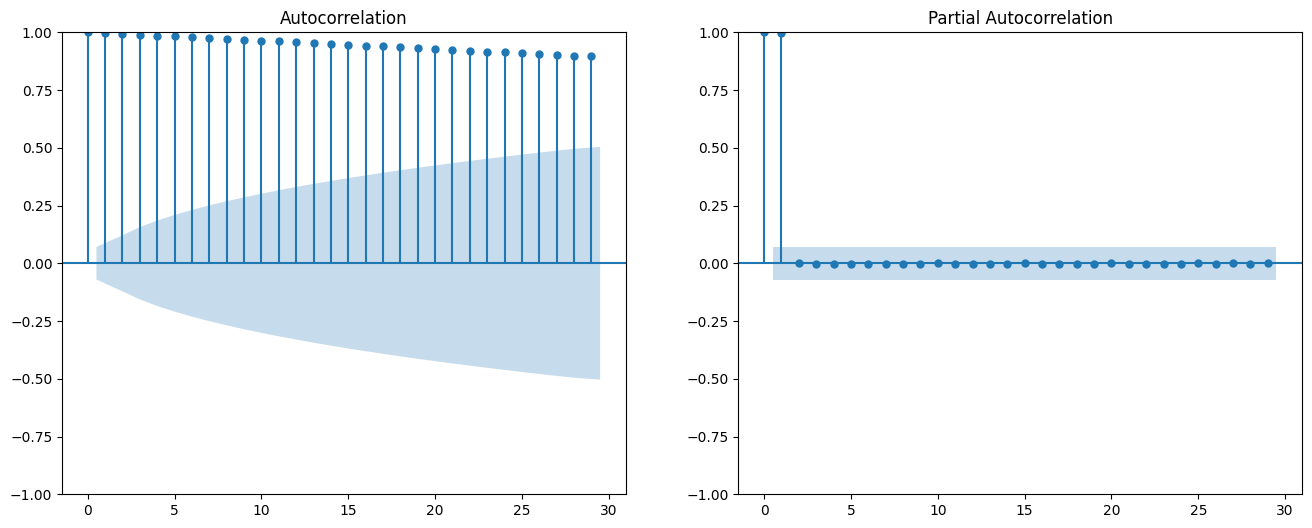

In [27]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(train_df_no_anomalies["PCE_boxcox"], ax=axes[0])
plot_pacf(train_df_no_anomalies["PCE_boxcox"], ax=axes[1])
plt.show()

- There is a **slow linear decay** in ACF plot.
- This means that the series is not stationary.
- No need to interpret PACF.

## KPSS Test

### KPSS for Stationarity

- H0: The time series stationary.
- H1: The time series is not stationary.

In [28]:
from statsmodels.tsa.stattools import kpss

result = kpss(train_df_no_anomalies["PCE_boxcox"], regression="c")

/tmp/ipykernel_31320/4126133508.py:3: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




In [29]:
print(f"KPSS Stationary Test: Statistic p-value={result[1]}")

KPSS Stationary Test: Statistic p-value=0.01


- We reject the null hypothesis since the p-value(0.01) is smaller than 0.05.
- That means we do not have enough evidence to claim that the process is stationary.
- Therefore,the series is not stationary.
- Since we concluded that the series is not stationary, now we apply second KPSS test to determine which kind oftrendexists in the series

### KPSS for Trend

- H0: There is a deterministic trend
- H1: There is a stochastic trend

In [30]:
result = kpss(train_df_no_anomalies["PCE_boxcox"], regression="ct")

/tmp/ipykernel_31320/2384238099.py:1: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




In [31]:
print(f"KPSS Trend Test: Statistic p-value={result[1]}")

KPSS Trend Test: Statistic p-value=0.01


- Since p value(0.01) is less than alpha(0.05), we reject the null hypothesis.
- Therefore, we have enough evidence to conclude that the series have stochastic trend.

## Augmented Dickey-Fuller (ADF) Test

- H0: The process has unit root (non-stationary).
- H1: The process is stationary.

In [32]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(
    train_df_no_anomalies["PCE_boxcox"],
    regression="c",
    maxlag=1,
)
print(f"ADF Test: p-value={result[1]}")

ADF Test: p-value=0.9895429284387574


- Since p value(0.98) is greater than alpha=0.05 , we fail to reject H0.
- It means that we don’t have enough evidence to claim that we have a stationary series.
- We have a **unit root** in the series.
- The series is not stationary.

Now, we add trend term to the model and test the hypothesis that:

- H0: There is a stochastic trend
- H1: There is a deterministic trend.

In [33]:
result = adfuller(
    train_df_no_anomalies["PCE_boxcox"],
    regression="ct",
    maxlag=1,
)
print(f"ADF Trend Test: p-value={result[1]}")

ADF Trend Test: p-value=0.8372847773306702


- Since the p-value(0.83) is greater than 0.05, we cannot reject the null hypothesis.
- This indicates that the series is non-stationary with a stochastic trend.
- Therefore, we should apply differencing.

## 

## Differencing

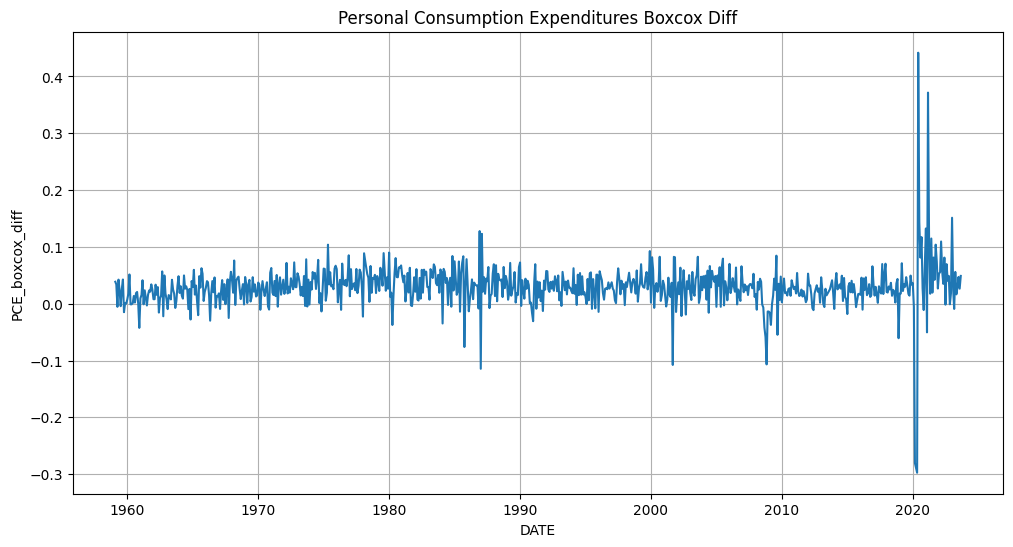

In [34]:
train_diff = train_df_no_anomalies["PCE_boxcox"].diff().dropna()
train_diff = train_diff.to_frame(name="PCE_boxcox_diff")

# Plot the data

plt.figure(figsize=(12, 6))
sns.lineplot(x=train_diff.index, y=train_diff["PCE_boxcox_diff"])
plt.title("Personal Consumption Expenditures Boxcox Diff")
plt.grid(True)
plt.show()


The process looks like stationary around mean 0.

### KPSS for Stationarity

- H0: The time series stationary.
- H1: The time series is not stationary

In [35]:
from statsmodels.tsa.stattools import kpss

result = kpss(train_diff["PCE_boxcox_diff"], regression="c")

/tmp/ipykernel_31320/3752169172.py:3: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




In [36]:
print(f"KPSS Stationary Test: Statistic p-value={result[1]}")

KPSS Stationary Test: Statistic p-value=0.1


- The p-value(0.1) is greater than 0.05. Therefore, we fail to reject H0.
- We conclude that the differencing series is stationary.

### Augmented Dickey-Fuller (ADF) Test

- H0: The process has unit root (non-stationary).
- H1: The process is stationary.

In [37]:
result = adfuller(train_diff["PCE_boxcox_diff"], regression="n", maxlag=1)
print(f"ADF Test: p-value={result[1]}")

ADF Test: p-value=4.5879440327791245e-21


- The p-value is smaller than 0.05, so we we reject the HO.
- The series is stationary.

**Both KPSS and ADF tests indicate that the differencing series is now stationary.**

### ACF and PACF Plots

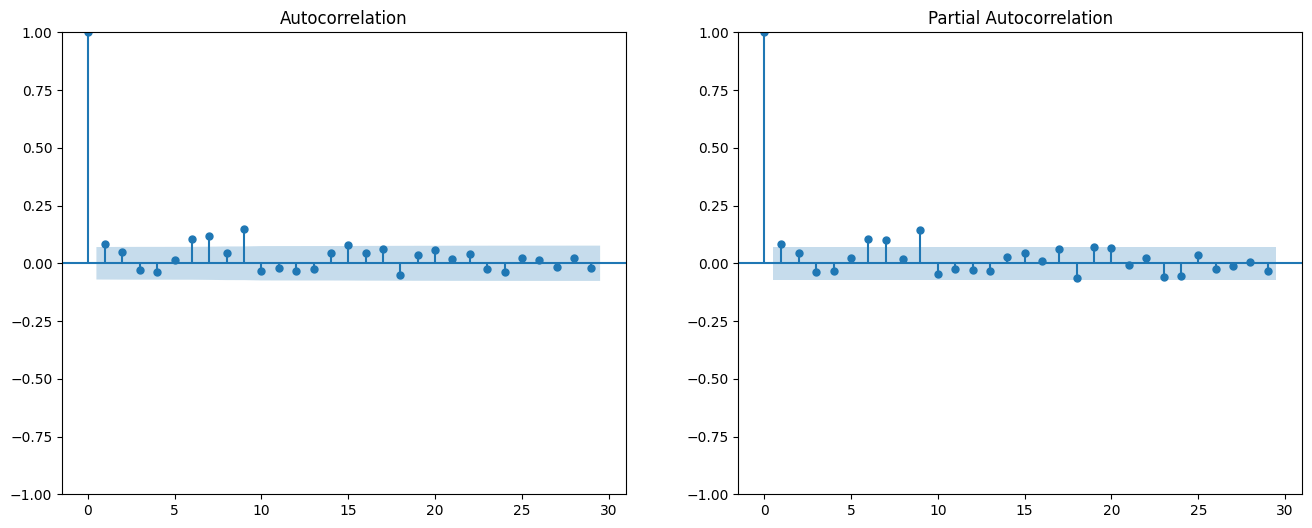

In [38]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(train_diff["PCE_boxcox_diff"], ax=axes[0])

plot_pacf(train_diff["PCE_boxcox_diff"], ax=axes[1])
plt.show()

- In the ACF plot of the differencing series, there is a significant spike at lag1.
- In the PACF of the differencing series, there is a significant spike at lag1.
- Suggested model can be ARIMA(1,1,1).

## Suggest Model

In [39]:
import warnings

warnings.filterwarnings("ignore", ".*possible convergence problem.*")

In [ ]:
train_diff_copy = train_diff.copy()

# Convert the index to PeriodIndex for sktime
train_diff_copy.index = pd.PeriodIndex(train_diff_copy.index, freq="M", name="Period")

In [41]:
from sktime.forecasting.arima import AutoARIMA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from sktime.forecasting.arima import AutoARIMA

forecaster = AutoARIMA(sp=12, max_p=2, max_d=2, max_q=2)


forecaster.fit(train_diff_copy["PCE_boxcox_diff"])
forecaster.get_fitted_params()

/home/betul/DataScientist_Development/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/home/betul/DataScientist_Development/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/home/betul/DataScientist_Development/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



{'intercept': 0.026620026812532564,
 'ar.L1': 0.08203686041528199,
 'sigma2': 0.0015380894593220215,
 'order': (1, 0, 0),
 'seasonal_order': (0, 0, 0, 12),
 'aic': -2817.921057375619,
 'aicc': -2817.8899692927175,
 'bic': -2803.958599815069,
 'hqic': -2812.549610782147}

In [49]:
forecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  776
Model:               SARIMAX(1, 0, 0)   Log Likelihood                1411.961
Date:                Sun, 08 Dec 2024   AIC                          -2817.921
Time:                        13:21:24   BIC                          -2803.959
Sample:                    02-28-1959   HQIC                         -2812.550
                         - 09-30-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0266      0.002     16.861      0.000       0.024       0.030
ar.L1          0.0820      0.009      8.706      0.000       0.064       0.101
sigma2         0.0015   1.75e-05     87.776      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             52635.92
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               5.27   Skew:                             0.92
Prob(H) (two-sided):                  0.00   Kurtosis:                        43.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
from sktime.forecasting.statsforecast import StatsForecastAutoARIMA


forecaster = StatsForecastAutoARIMA(sp=12, max_p=2, max_d=2, max_q=2)
forecaster.fit(train_diff_copy["PCE_boxcox_diff"])

In [45]:
forecaster.get_fitted_params()

{'model': {'coef': {'ma1': 0.08111351876414716,
   'ma2': 0.05836103053202204,
   'intercept': 0.029006715461083132},
  'sigma2': 0.0015405919059573452,
  'var_coef': array([[ 3.95241319e-04, -3.95235589e-04,  2.52169450e-06],
         [-3.95235589e-04,  3.95232971e-04, -2.52168754e-06],
         [ 2.52169450e-06, -2.52168754e-06,  2.57165099e-06]]),
  'mask': array([ True,  True,  True]),
  'loglik': 1412.92861760293,
  'aic': -2817.85723520586,
  'arma': (0, 2, 0, 0, 1, 0, 0),
  'residuals': array([ 9.59467148e-03,  4.11437581e-03, -3.53519345e-02,  1.60073537e-02,
         -5.58910685e-03, -3.37933232e-02, -1.68519827e-04,  1.55950952e-02,
         -4.51301519e-02, -2.51924945e-02, -2.43294214e-02, -1.81243462e-02,
         -8.10391156e-03,  2.42166092e-02, -3.15432177e-02, -2.89068498e-02,
         -2.37756750e-02, -1.18234429e-02, -2.45764782e-02, -7.61492921e-03,
         -6.26069624e-03, -2.80544732e-02, -6.88938539e-02, -1.24104529e-02,
         -8.40569761e-03,  1.36616181e-02

Suggested model is ARIMA(1,1,0)

In [64]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

models = [
    (1,0,0),
     (0,0,2)
]

# Dictionary to store results
results = {
    'order': [],
    'aic': [],
    'bic': [],
    'hqic': [],
    'mse': []
}

# Estimate models and collect metrics
for order in models:
    try:
        # Fit ARIMA with MLE
        model = ARIMA(train_diff_copy["PCE_boxcox_diff"], order=order)
        fitted = model.fit()
        
        # Store results
        results['order'].append(order)
        results['aic'].append(fitted.aic)
        results['bic'].append(fitted.bic)
        results['hqic'].append(fitted.hqic)
        results['mse'].append(mean_squared_error(train_diff_copy["PCE_boxcox_diff"], fitted.fittedvalues))
        
    except:
        # If MLE fails, try conditional sum of squares
        try:
            fitted = model.fit(method='css')
            
            results['order'].append(order)
            results['aic'].append(fitted.aic)
            results['bic'].append(fitted.bic)
            results['hqic'].append(fitted.hqic)
            results['mse'].append(mean_squared_error(train_diff_copy["PCE_boxcox_diff"], fitted.fittedvalues))
            
        except:
            print(f"Could not estimate model with order {order}")
            continue

# Create comparison DataFrame
comparison = pd.DataFrame(results)
comparison = comparison.sort_values('aic')

# Display results
print("\nModel Comparison:")
print(comparison)

# Get best model according to AIC
best_order = comparison.iloc[0]['order']
print(f"\nBest model order (AIC): {best_order}")

# Fit final model
final_model = ARIMA(train_diff_copy["PCE_boxcox_diff"], order=best_order)
final_fit = final_model.fit()
print("\nFinal Model Summary:")
print(final_fit.summary())


Model Comparison:
       order          aic          bic         hqic       mse
0  (1, 0, 0) -2817.921077 -2803.958619 -2812.549630  0.001538
1  (0, 0, 2) -2817.856464 -2799.239854 -2810.694535  0.001535

Best model order (AIC): (1, 0, 0)

Final Model Summary:
                               SARIMAX Results                                
Dep. Variable:        PCE_boxcox_diff   No. Observations:                  776
Model:                 ARIMA(1, 0, 0)   Log Likelihood                1411.961
Date:                Sun, 08 Dec 2024   AIC                          -2817.921
Time:                        15:16:07   BIC                          -2803.959
Sample:                    02-28-1959   HQIC                         -2812.550
                         - 09-30-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------

estimate the parameters

In [67]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")
train_diff_copy = pd.DataFrame(train_diff_copy, columns=["PCE_boxcox_diff"])

# Fit ARIMA(1, 0, 0) using CSS-MLE (Conditional Sum of Squares Maximum Likelihood Estimation)
model_mle = ARIMA(train_diff_copy["PCE_boxcox_diff"], order=(1, 0, 0))
fitted_model_mle = model_mle.fit(method="innovations_mle")

# Print MLE parameter estimates using 
print("Maximum Likelihood Estimation (MLE):")
print(f"AR(1) coefficient: {fitted_model_mle.params['ar.L1']}")
print(f"Intercept: {fitted_model_mle.params['const']}")
print(fitted_model_mle.summary())


Maximum Likelihood Estimation (MLE):
AR(1) coefficient: 0.08193752272798258
Intercept: 0.02900445726719246
                               SARIMAX Results                                
Dep. Variable:        PCE_boxcox_diff   No. Observations:                  776
Model:                 ARIMA(1, 0, 0)   Log Likelihood                1411.961
Date:                Sun, 08 Dec 2024   AIC                          -2817.921
Time:                        15:24:57   BIC                          -2803.959
Sample:                    02-28-1959   HQIC                         -2812.550
                         - 09-30-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0290      0.002     15.520      0.000       0.025       0.033
ar.L1          0.0819   

## Diagnostic Checking

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import het_arch
from scipy.stats import shapiro
import seaborn as sns

### A) Portmanteau test and ACF/PACF plots

In [ ]:
residuals = fitted_model_mle.resid
standardized_residuals = (residuals - np.mean(residuals)) / np.std(residuals)

# Ljung-Box Q-test
lb_test = acorr_ljungbox(residuals, return_df=True)
print("Ljung-Box Test Results:")
lb_test["lb_pvalue"]

Ljung-Box Test Results:


1     0.924611
2     0.447356
3     0.510090
4     0.504803
5     0.636617
6     0.114383
7     0.007367
8     0.011739
9     0.000028
10    0.000032
Name: lb_pvalue, dtype: float64

<Figure size 1200x500 with 0 Axes>

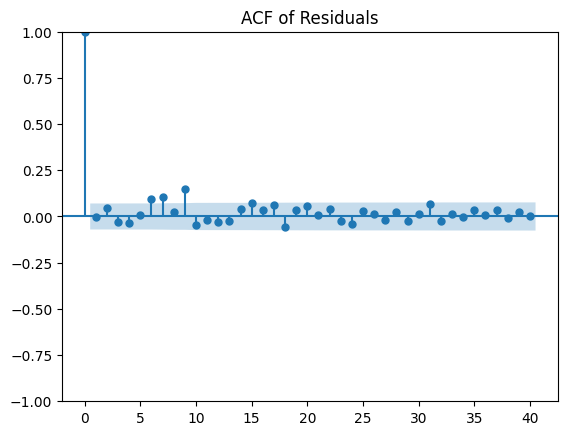

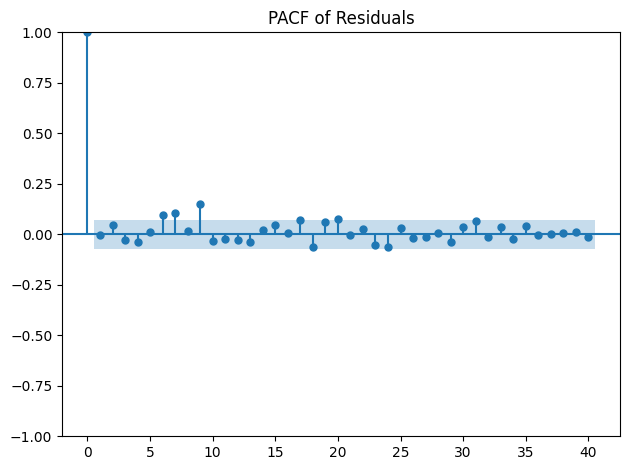

In [93]:
plt.figure(figsize=(12, 5))
plot_acf(residuals, lags=40, title='ACF of Residuals')
plot_pacf(residuals, lags=40, title='PACF of Residuals')
plt.tight_layout()
plt.show()

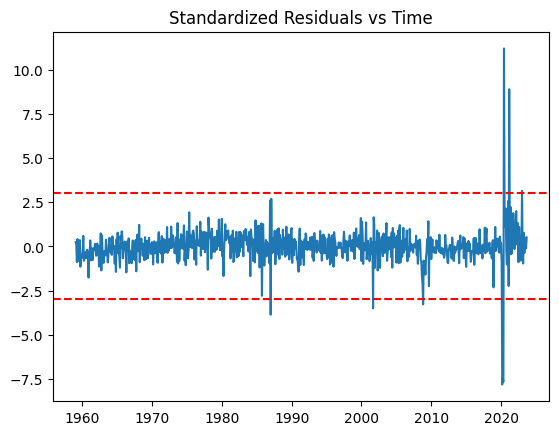

In [79]:
plt.plot(standardized_residuals.to_timestamp())
plt.title('Standardized Residuals vs Time')
plt.axhline(y=3, color='r', linestyle='--')
plt.axhline(y=-3, color='r', linestyle='--')

### B) Normality checks

Text(0.5, 1.0, 'Histogram of Residuals')

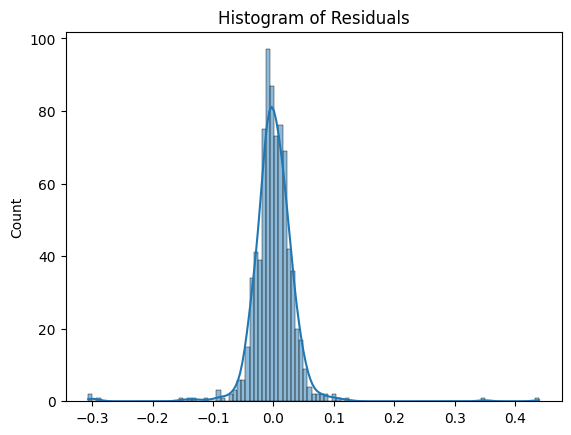

In [ ]:
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')

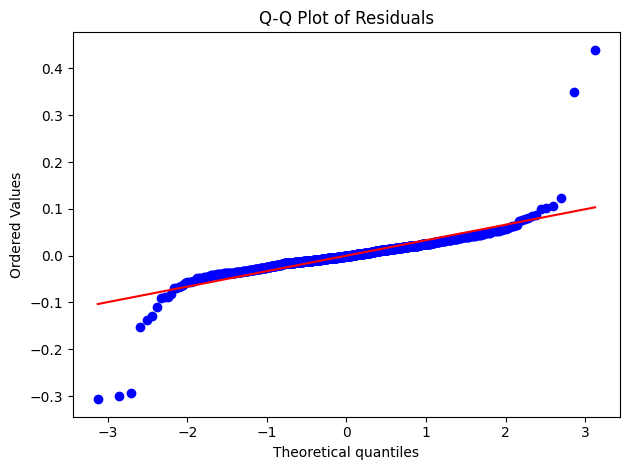

In [82]:
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.tight_layout()
plt.show()

In [91]:
print("Shapiro-Wilk Test Results:")
print(shapiro(residuals))

Shapiro-Wilk Test Results:
ShapiroResult(statistic=0.714676788351002, pvalue=2.5693560926044224e-34)


- The p value of the Shapiro-Wilk test is smaller than 0.05, so we can reject the H0 which is residuals is distribudted normally. 
- Residuals are not distributed normally.

In [ ]:
jb, jb_p_value, skew, kurtosis = jarque_bera(residuals)
print("Jarque-Bera p value:", jb_p_value)

Jarque-Bera p value: 0.0


- The p value of the Jarque-Bera test is smaller than 0.05, so we can reject the H0 which is residuals is distribudted normally. 
- Residuals are not distributed normally.

### C) Breusch-Godfrey test for autocorrelation.

In [ ]:
from statsmodels.stats.diagnostic import acorr_breusch_godfrey

bg_test = acorr_breusch_godfrey(fitted_model_mle, nlags=20)

# Print the results
print("Breusch-Godfrey Test Results:")
print(f"LM Statistic: {bg_test[0]}")
print(f"p-value: {bg_test[1]}")
print(f"F-Statistic: {bg_test[2]}")
print(f"F p-value: {bg_test[3]}")

Breusch-Godfrey Test Results:
LM Statistic: 55.06678120772087
p-value: 4.012841978690555e-05
F-Statistic: 2.885920254463241
F p-value: 2.6414759178229736e-05


- The null hypothesis is the Breusch-Godfrey test that there is no serial correlation.
- The results of the Breusch-Godfrey test indicate that there is significant autocorrelation in the residuals.

### D) Heteroscedasticity checks

<Figure size 1200x500 with 0 Axes>

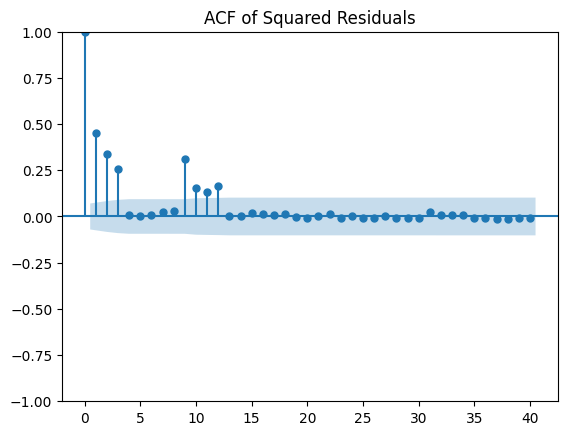

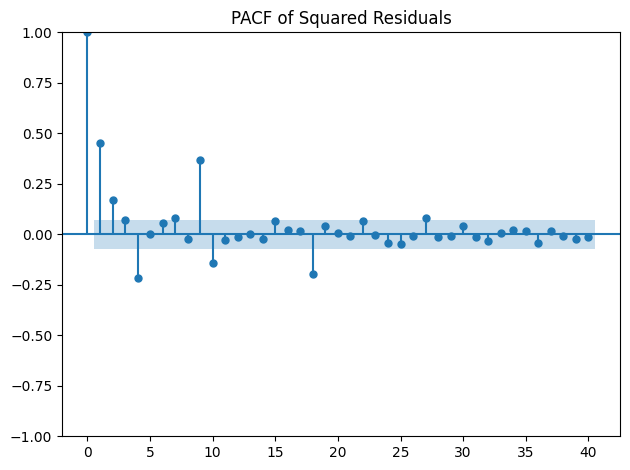

In [ ]:
plt.figure(figsize=(12, 5))
plot_acf(residuals**2, lags=40, title='ACF of Squared Residuals')
plot_pacf(residuals**2, lags=40, title='PACF of Squared Residuals')
plt.tight_layout()
plt.show()

In [ ]:
print("\nARCH LM Test Results:")
arch_test = het_arch(residuals)
print(f"LM Statistic: {arch_test[0]}")
print(f"P-value: {arch_test[1]}")
print(f"F Statistic: {arch_test[2]}")
print(f"F-test p-value: {arch_test[3]}")


ARCH LM Test Results:
LM Statistic: 294.57796179839966
P-value: 2.175465436939507e-57
F Statistic: 47.17776071866229
F-test p-value: 5.035549096430121e-73


- The ARCH LM test results indicate that there is significant heteroskedasticity in the residuals.

## Forecast

In [109]:
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.tbats import TBATS
from sktime.forecasting.base import ForecastingHorizon


train_df_copy = train_df.copy()
test_df_copy = test_df.copy()

# Convert the index to PeriodIndex
train_df_copy.index = pd.PeriodIndex(train_df_copy.index, freq="M", name="Period")
test_df_copy.index = pd.PeriodIndex(test_df_copy.index, freq="M", name="Period")

# Define the forecasting horizon
fh = ForecastingHorizon(test_df_copy.index, is_relative=False)

# ETS Model
ets_model = AutoETS(auto=True, sp=12, n_jobs=-1)
ets_model.fit(train_df_copy["PCE"])
ets_forecast = ets_model.predict(fh)
ets_forecast_intervals = ets_model.predict_interval(fh)

# Prophet Model
prophet_model = Prophet()
prophet_model.fit(train_df_copy["PCE"])
prophet_forecast = prophet_model.predict(fh)
prophet_forecast_intervals = prophet_model.predict_interval(fh)

## TBATS Model
# tbats_model = TBATS(sp=12, use_arma_errors=True, n_jobs=-1)
# tbats_model.fit(train_df_copy["PCE"])
# tbats_forecast = tbats_model.predict(fh)

16:50:19 - cmdstanpy - INFO - Chain [1] start processing
16:50:20 - cmdstanpy - INFO - Chain [1] done processing


In [116]:
ets_forecast_intervals[('PCE', 0.9, 'lower')]

2023-10    18836.099379
2023-11    18788.535223
2023-12    18789.391554
2024-01    18802.506171
2024-02    18831.962372
2024-03    18848.878212
2024-04    18888.708004
2024-05    18901.670100
2024-06    18960.187495
2024-07    18975.952189
2024-08    19021.965782
2024-09    19063.486199
Freq: M, Name: (PCE, 0.9, lower), dtype: float64

KeyError: 'lower'

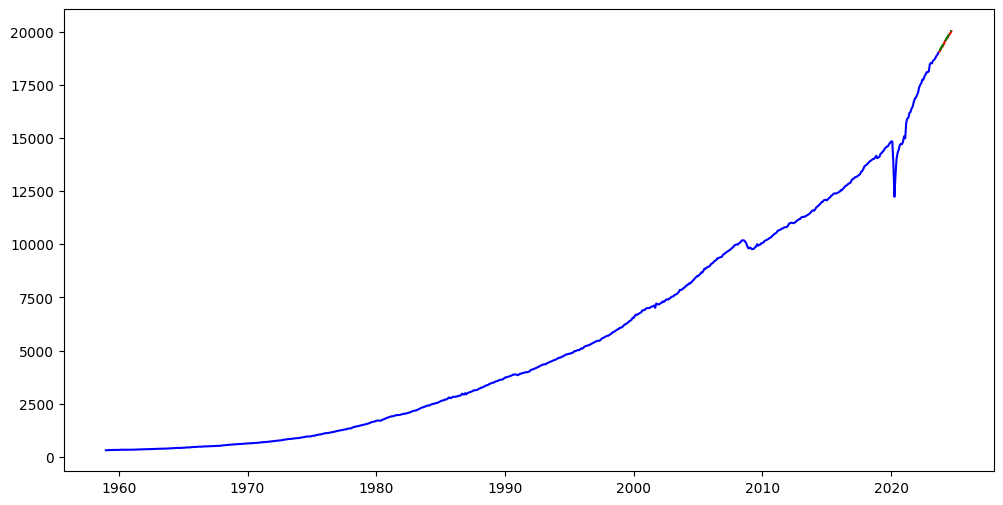

In [ ]:
plt.figure(figsize=(12,6))

# Plot training data
plt.plot(train_df_copy.index.to_timestamp(), train_df_copy.values, label='Training Data', color='blue')

# Plot test data 
plt.plot(test_df_copy.index.to_timestamp(), test_df_copy.values, label='Test Data', color='red')

# Plot ETS forecast
plt.plot(ets_forecast.index.to_timestamp(), ets_forecast.values, label='ETS Forecast', color='green', linestyle='--')
plt.fill_between(ets_forecast.index.to_timestamp(), 
                 ets_forecast_intervals[('PCE', 0.9, 'lower')].values,
                 ets_forecast_intervals[('PCE', 0.9, 'upper')].values,
                 color='green', alpha=0.2, label='ETS 90% CI')

# Plot Prophet forecast
plt.plot(prophet_forecast.index.to_timestamp(), prophet_forecast.values, label='Prophet Forecast', color='orange', linestyle='--')

plt.title('Time Series Data and Forecasts Zoomed In')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

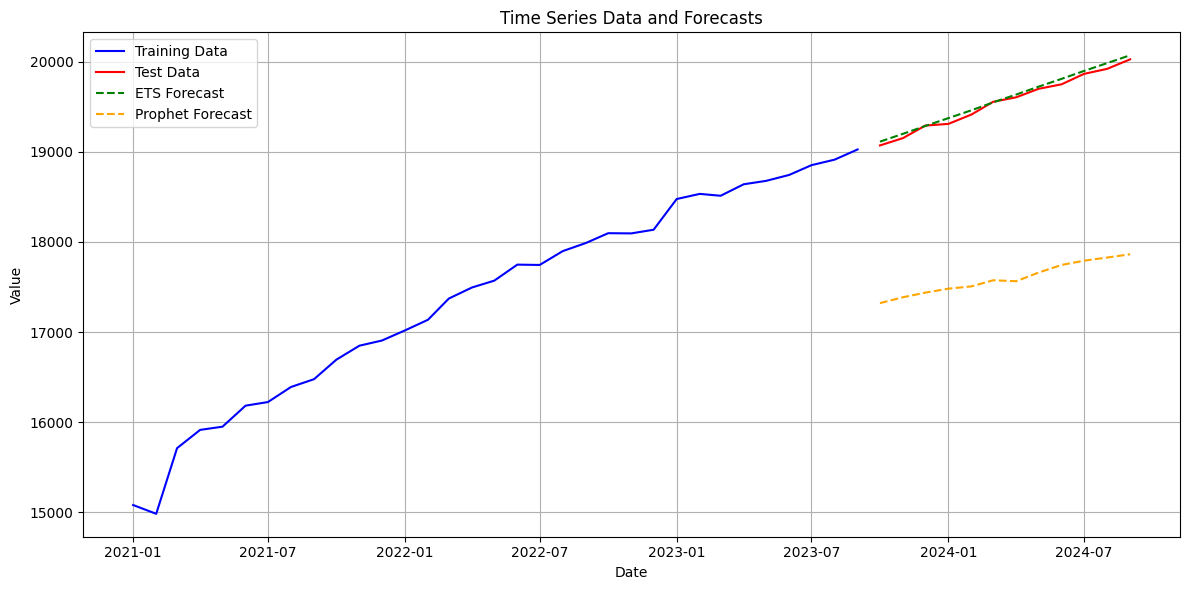

In [ ]:
plt.figure(figsize=(12,6))

# Plot training data
plt.plot(train_df_copy.loc['2021':].index.to_timestamp(), train_df_copy.loc['2021':].values, label='Training Data', color='blue')

# Plot test data 
plt.plot(test_df_copy.index.to_timestamp(), test_df_copy.values, label='Test Data', color='red')

# Plot ETS forecast
plt.plot(ets_forecast.index.to_timestamp(), ets_forecast.values, label='ETS Forecast', color='green', linestyle='--')

# Plot Prophet forecast
plt.plot(prophet_forecast.index.to_timestamp(), prophet_forecast.values, label='Prophet Forecast', color='orange', linestyle='--')

plt.title('Time Series Data and Forecasts Zoomed In')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()